**Lung Cancer Detection using Deep Learning**





Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Install requirements

In [ ]:
!pip install Pillow
!pip install scipy==1.1.0
!pip install SimpleITK
!pip install keras
!pip install tensorflow

     |████████████████████████████████| 31.2 MB 55 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.2 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 48.4 MB 29 kB/s 


Import all necessary libraries

In [ ]:
import tensorflow as tf
import keras
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import glob
from PIL import Image, ImageEnhance
import multiprocessing
from scipy.misc import imread, imresize
import scipy.misc
import cv2
from sklearn.model_selection import train_test_split
import h5py
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None



Load Data

In [ ]:
annotations = pd.read_csv('/content/gdrive/My Drive/lung_cancer_mid/annotations.csv')
candidates = pd.read_csv('/content/gdrive/My Drive/lung_cancer_mid/candidates.csv')

In [ ]:
annotations

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
...,...,...,...,...,...
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-160.856298,-28.560349,-269.168728,5.053694
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-102.189570,-73.865766,-220.536241,4.556101
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-37.535409,64.041949,-127.687101,4.357368
1184,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,43.196112,74.438486,-200.523314,4.277203


In [ ]:
#Number of values with 1
candidates['class'].sum()

1351

In [ ]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [ ]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


In [ ]:
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


Define a class to crop out part of the image which has cancer (Same as the one used in preprocessing)

In [ ]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('/content/gdrive/My Drive/lung_cancer_mid/seg-lungs-LUNA16/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [ ]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

In [ ]:
positives

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [ ]:
negatives

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            551055, 551056, 551057, 551058, 551059, 551060, 551061, 551062,
            551063, 551064],
           dtype='int64', length=549714)

In [ ]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [ ]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [ ]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [ ]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [ ]:
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
X_train.size

25936

In [ ]:
y_train

178085    0
108126    0
416697    0
342095    0
116478    0
         ..
469116    0
164439    0
333192    1
358382    0
536292    0
Name: class, Length: 6484, dtype: int64

In [ ]:
y_test

189342    0
145102    0
31546     0
441280    1
215578    0
         ..
87015     0
245189    0
533231    0
52755     0
379730    0
Name: class, Length: 1622, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [ ]:
X_train.size

20748

In [ ]:
X_train

,seriesuid,coordX,coordY,coordZ
59270,1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,-97.808167,3.897917,-201.030000
150277,1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929...,58.990000,-24.230000,-18.320000
432208,1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537...,-50.307219,159.439740,-113.418797
423122,1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295...,-106.731000,-104.468000,751.163333
344581,1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932...,67.240000,-32.590000,-107.790000
...,...,...,...,...
323102,1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991...,-22.239361,84.653132,-161.740390
94004,1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752...,52.320000,65.000000,-117.870000
459476,1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263...,-112.420630,37.648160,-67.928064
241550,1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143...,-27.740000,-121.660000,-254.130000


In [ ]:
y_train

59270     0
150277    0
432208    0
423122    0
344581    0
         ..
323102    0
94004     0
459476    1
241550    0
211695    0
Name: class, Length: 5187, dtype: int64

In [ ]:
len(X_train)

5187

In [ ]:
#X_train.to_pickle('/content/gdrive/MyDrive/lung_cancer_mid/preprocessed_data/traindata')
#X_test.to_pickle('/content/gdrive/MyDrive/lung_cancer_mid/preprocessed_data/testdata')
#X_val.to_pickle('/content/gdrive/MyDrive/lung_cancer_mid/preprocessed_data/valdata')

In [ ]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [ ]:
print('number of positive cases are ' + str(y_train.sum()))
print('total set size is ' + str(len(y_train)))
print('percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train)))

number of positive cases are 845
total set size is 5187
percentage of positive cases are 0.16290726817042606


Since number of positive cases are very few, we take only a few number of negative cases and increase number of positive cases

In [ ]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print(len(X_train_new), len(y_train_new))

6877 6877


In [ ]:
X_train_new

,seriesuid,coordX,coordY,coordZ
59270,1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,-97.808167,3.897917,-201.030000
150277,1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929...,58.990000,-24.230000,-18.320000
432208,1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537...,-50.307219,159.439740,-113.418797
423122,1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295...,-106.731000,-104.468000,751.163333
344581,1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932...,67.240000,-32.590000,-107.790000
...,...,...,...,...
2436163,1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286...,88.955096,224.250740,-586.901865
2013078,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.089458,72.608061,1791.668825
2352132,1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547...,100.136716,3.904990,-93.909072
2188812,1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895...,118.180000,-42.910000,-247.440000


In [ ]:
y_train_new

59270      0.0
150277     0.0
432208     0.0
423122     0.0
344581     0.0
          ... 
2436163    1.0
2013078    1.0
2352132    1.0
2188812    1.0
2459476    1.0
Name: class, Length: 6877, dtype: float64

In [ ]:
X_train_new.index

Int64Index([  59270,  150277,  432208,  423122,  344581,   75111,  246217,
             292479,  147683,  468235,
            ...
            2282167, 2300642, 2021354, 2461166, 2332952, 2436163, 2013078,
            2352132, 2188812, 2459476],
           dtype='int64', length=6877)

In [ ]:
class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Original shape of input image:  (50, 50)


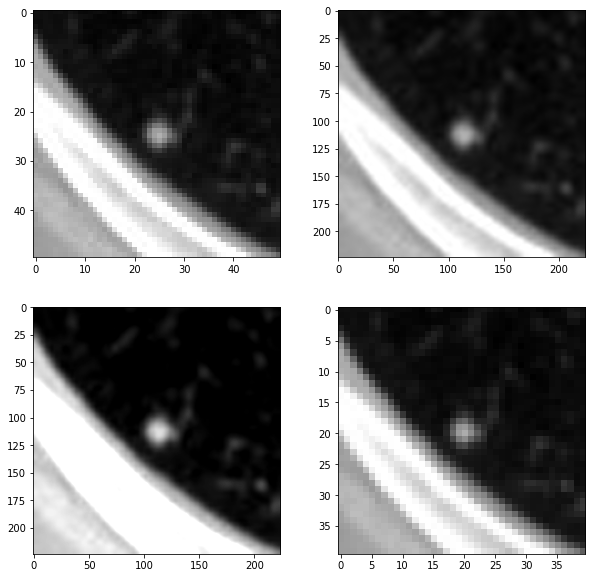

In [ ]:
dirName = '/content/gdrive/My Drive/lung_cancer_mid/data/train/'
plt.figure(figsize = (10,10))
inp = imread(dirName + 'image_'+ str(30517) + '.jpg')
print ("Original shape of input image: ", inp.shape)
plt.subplot(221)
plt.imshow(inp, cmap='gray')
plt.grid(False)

inp = PreProcessing(inp).upsample_data()
Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()
plt.subplot(222)
plt.imshow(inp2, cmap='gray')
plt.grid(False)

inp3 = ImageEnhance.Contrast(Image.fromarray(inp))
contrast = 1.5
inp3 = inp3.enhance(contrast)
plt.subplot(223)
plt.imshow(inp3, cmap='gray')
plt.grid(False)

inp4 = Pp.downsample_data()
plt.subplot(224)
plt.imshow(inp4,cmap='gray')
plt.grid(False)

In [ ]:
inp.shape

(224, 224)

In [ ]:
inp.dtype

dtype('uint8')

In [ ]:
y_train_new.values.astype(int)

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
dirName

'/content/gdrive/My Drive/lung_cancer_mid/data/train/'

Some data processing

In [ ]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/lung_cancer_mid/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_2459476.jpg'],
      dtype='<U69')

In [ ]:
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/lung_cancer_mid/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/lung_cancer_mid/data/train/image_2459476.jpg'],
      dtype='<U69')

In [ ]:
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [ ]:
traindata

array([(b'/content/gdrive/My Drive/lung_cancer', 0),
       (b'/content/gdrive/My Drive/lung_cancer', 0),
       (b'/content/gdrive/My Drive/lung_cancer', 0), ...,
       (b'/content/gdrive/My Drive/lung_cancer', 1),
       (b'/content/gdrive/My Drive/lung_cancer', 1),
       (b'/content/gdrive/My Drive/lung_cancer', 1)],
      dtype=[('var1', 'S36'), ('var2', '<i8')])

In [ ]:
# Build a HDF5 dataset (only required once)

#build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)

In [ ]:
# Load HDF5 dataset

h5f = h5py.File('/content/gdrive/My Drive/lung_cancer_mid/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/My Drive/lung_cancer_mid/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [ ]:
X_train_images

<HDF5 dataset "X": shape (5187, 50, 50), type "<f4">

In [ ]:
Y_train_labels

<HDF5 dataset "Y": shape (5187, 2), type "<f4">

In [ ]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)

In [ ]:
print(X_train_processing.shape)
print(X_val_processing.shape)

(5187, 50, 50)
(1297, 50, 50)


In [ ]:
print(X_train_processing.dtype)
print(X_val_processing.dtype)

float32
float32


In [ ]:
img_test = X_train_processing[1000]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [ ]:
print(Y_train_labels[1000])

[1. 0.]


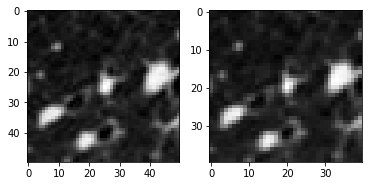

In [ ]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_downsampled,cmap='gray')

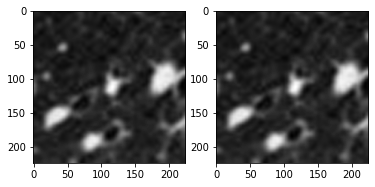

In [ ]:
img_test_subtracted_mean = PreProcessing(img_test_upsampled).subtract_mean()
plt.subplot(121)
plt.imshow(img_test_upsampled,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_subtracted_mean,cmap='gray')

In [ ]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

In [ ]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)


In [ ]:
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

float32
float32
float32
float32


In [ ]:
h5f2 = h5py.File('/content/gdrive/My Drive/lung_cancer_mid/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [ ]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)

In [ ]:
print(X_test_images_np.shape)
print(y_test_labels_np.shape)

(1622, 50, 50, 1)
(1622, 2)


In [ ]:
print(X_test_images_np.dtype)
print(y_test_labels_np.dtype)

float32
float32


Create model 1

In [ ]:
"""
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.1))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'));return model

mobile = define_model()
"""

In [ ]:
"""
mobile.summary()
"""

In [ ]:
"""
op_layer = mobile.output
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(op_layer)
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(final_layer)
final_layer = Dense(2,activation= 'softmax')(final_layer)

# Define model input and output
model = Model(inputs = mobile.input , outputs = final_layer)
opt = SGD(lr=0.001, momentum=0.9)

optimizer_sgd = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])
"""

In [ ]:
"""
model.summary()
"""

In [ ]:
"""
# plot diagnostic learning curves

def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
  """

In [ ]:
"""
callbacks = [
    keras.callbacks.ModelCheckpoint('classification_deep_conv_model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau()]
"""

In [ ]:
"""
# run the test harness for evaluating a model
def run_test_harness():
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	it_train = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)
	# fit model
	steps = int(X_train_images_np.shape[0] / 64)
	hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=500, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks)
	# evaluate model
	_, acc = model.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(hist)

# entry point, run the test harness
run_test_harness()
"""

Define model 2 (similar to YOLO)

In [ ]:
def define_model():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same', input_shape=(50,50,1)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=(3,3), strides=2, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=64, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=2, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=2, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=2, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=255, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.UpSampling2D(size=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=255, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.UpSampling2D(size=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=255, kernel_size=(1,1), strides=1, activation=tf.nn.leaky_relu, padding='same'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128, activation=tf.nn.leaky_relu))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(128, activation=tf.nn.leaky_relu))
  return model

mobile = define_model()


In [ ]:
mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        1

In [ ]:
op_layer = mobile.output
final_layer = Dense(128,activation='relu')(op_layer)
final_layer = Dense(128,activation='relu')(final_layer)
final_layer = Dense(2,activation= 'softmax')(final_layer)

# Define model input and output
model = Model(inputs = mobile.input , outputs = final_layer)
opt = SGD(lr=0.001, momentum=0.9)

optimizer_sgd = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 32)        128   

In [ ]:
# plot diagnostic learning curves

def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('classification_deep_conv_model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau()]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
81/81 [==============================] - 81s 233ms/step - loss: 0.5292 - accuracy: 0.7826 - val_loss: 0.4673 - val_accuracy: 0.8273
Epoch 2/500
81/81 [==============================] - 12s 152ms/step - loss: 0.4500 - accuracy: 0.8400 - val_loss: 0.4579 - val_accuracy: 0.8273
Epoch 3/500
81/81 [==============================] - 13s 154ms/step - loss: 0.4565 - accuracy: 0.8342 - val_loss: 0.5536 - val_accuracy: 0.8273
Epoch 4/500
81/81 [==============================] - 13s 157ms/step - loss: 0.4556 - accuracy: 0.8385 - val_loss: 0.4787 - val_accuracy: 0.8273
Epoch 5/500
81/81 [==============================] - 13s 157ms/step - loss: 0.4476 - accuracy: 0.8348 - val_loss: 3.8406 - val_accuracy: 0.8273
Epoch 6/500
81/81 [==============================] - 13s 157ms/step - loss: 0.4455 - accuracy: 0.8413 - val_loss: 0.8567 - val_accuracy: 0.8273
Epoch 7/500
81/81 [==============================] - 13s 157ms/step - loss: 0.4635 - accuracy: 0.8287 - val_loss: 0.9368 - val_accuracy:

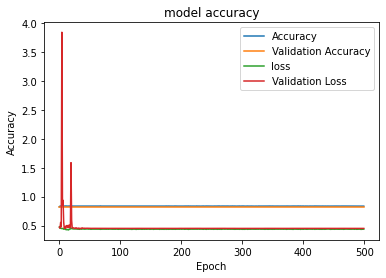

In [ ]:
# run the test harness for evaluating a model
#def run_test_harness():
	# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
it_train = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)
	# fit model
steps = int(X_train_images_np.shape[0] / 64)
hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=500, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks)
	# evaluate model
_, acc = model.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
print('> %.3f' % (acc * 100.0))
	# learning curves
summarize_diagnostics(hist)

# entry point, run the test harness
#run_test_harness()

In [ ]:
model_new_1 = keras.models.load_model("classification_deep_conv_model.h5")

ValueError: ignored

In [ ]:
model_new_1.summary()

In [ ]:

y_pred = model_new_1.predict(X_test_images_np)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_labels_np,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

In [ ]:
print('Classification report')
print(classification_report(y_true,y_p))